In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
#import scikitplot as skplt
import itertools

# Preprocesado de información

In [3]:
dataframe = pd.read_csv('sample_data/ObesityDataSet_raw_and_data_sinthetic.csv')

# Preprocesado de las caracteristicas categoricas a númericas.
my_dataframe = dataframe.copy()
my_dataframe = pd.concat([pd.get_dummies(my_dataframe['Gender'], prefix='Gender'), my_dataframe], axis=1)
my_dataframe = my_dataframe.drop(['Gender'], axis=1)
my_dataframe = pd.concat([pd.get_dummies(my_dataframe['family_history_with_overweight'], prefix='family_history_with_overweight'), my_dataframe], axis=1)
my_dataframe = my_dataframe.drop(['family_history_with_overweight'], axis=1)
my_dataframe = pd.concat([pd.get_dummies(my_dataframe['FAVC'], prefix='FAVC'), my_dataframe], axis=1)
my_dataframe = my_dataframe.drop(['FAVC'], axis=1)
my_dataframe = pd.concat([pd.get_dummies(my_dataframe['SMOKE'], prefix='SMOKE'), my_dataframe], axis=1)
my_dataframe = my_dataframe.drop(['SMOKE'], axis=1)
my_dataframe = pd.concat([pd.get_dummies(my_dataframe['SCC'], prefix='SCC'), my_dataframe], axis=1)
my_dataframe = my_dataframe.drop(['SCC'], axis=1)
my_dataframe = pd.concat([pd.get_dummies(my_dataframe['CAEC'], prefix='CAEC'), my_dataframe], axis=1)
my_dataframe = my_dataframe.drop(['CAEC'], axis=1)
my_dataframe = pd.concat([pd.get_dummies(my_dataframe['CALC'], prefix='CALC'), my_dataframe], axis=1)
my_dataframe = my_dataframe.drop(['CALC'], axis=1)
my_dataframe = pd.concat([pd.get_dummies(my_dataframe['MTRANS'], prefix='MTRANS'), my_dataframe], axis=1)
my_dataframe = my_dataframe.drop(['MTRANS'], axis=1)

# Preprocesado de la variable a predecir
mapping = {
    'Insufficient_Weight':1,
    'Normal_Weight':2,
    'Overweight_Level_I':3,
    'Overweight_Level_II':4,
    'Obesity_Type_I':5,
    'Obesity_Type_II':6,
    'Obesity_Type_III':7
}

my_dataframe['NObeyesdad'] = my_dataframe['NObeyesdad'].replace(mapping)

X = my_dataframe.values[:,0:31]
Y = my_dataframe['NObeyesdad'].values

# Matriz de confución 

In [5]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Curva ROC

In [6]:
def plot_roc(Xtest, Ytest, probs, xlabel):
    ns_probs = [0 for _ in range(len(Ytest))]
    
    probs = probs[:, 1]
    
    ns_auc = roc_auc_score(Ytest, ns_probs, multi_class="ovr",)
    print("Hola perros")
    auc = roc_auc_score(Ytest, probs)  

    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (auc))

    ns_fpr, ns_tpr, _ = roc_curve(Ytest, ns_probs)
    fpr, tpr, _ = roc_curve(Ytest, probs)   

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label= xlabel)

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    plt.tight_layout()
    # show the plot
    plt.show()

# Máquinas de Soporte Vectorial

In [7]:
from sklearn.svm import SVC
from itertools import *
from sklearn.multiclass import OneVsRestClassifier

## Etapa de validación

In [8]:
def funcionSVC(x, y, kernels, gammas,params_reg, impresion=True):
    """función que realizar experimentos sobre un SVM para clasificación
    
    x: numpy.Array, con las caracteristicas del problema
    y: numpy.Array, con la variable objetivo
    kernels: List[str], lista con valores a pasar 
        a sklearn correspondiente al kernel de la SVM
    gammas: List[float], lista con los valores a pasar a
        sklean correspondiente el valor de los coeficientes para usar en el
        kernel
    params_reg: List[float], lista con los valores a a pasar a 
        sklearn para ser usados como parametro de regularización
    estrategia: str, valor que puede ser ovo (para one vs one) o ovr 
        (para one vs rest)
    
    retorna: pd.Dataframe con las siguientes columnas:
        - 3 columnas con los tres parametros: kernel, gamma, param de regularizacion
        - error cuadratico medio en el cojunto entrenamiento (promedio de los 4 folds)
        - error cuadratico medio en el cojunto test (promedio de los 4 folds)
        - % de Vectores de Soporte promedio para los 4 folds (0 a 100)
    """
    idx = 0
    kf = KFold(n_splits=5)
    # crear una lista con la combinaciones de los elementos de cada list
    kernels_gammas_regs = list(itertools.product(kernels, gammas, params_reg))
    resultados = pd.DataFrame()
    
    for params in kernels_gammas_regs:
        ker, gam, param_reg = params
        
        #print("parametros usados", params) # puede usar para ver los params
        errores_train = []
        errores_test = []
        pct_support_vectors = []
        
        for train_index, test_index in kf.split(x):
            X_train, X_test = x[train_index], x[test_index]
            y_train, y_test = y[train_index], y[test_index]  
            # normalizar los datos
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)
            
            svm = SVC(C=param_reg, kernel=ker, gamma=gam)
            
            svm = OneVsRestClassifier(svm)               
            
            # Entrenar el modelo
            svm.fit(X=X_train, y=y_train)
            # calculo de errores
            y_train_pred = svm.predict(X=X_train)
            y_test_pred = svm.predict(X=X_test)
            # error y pct de vectores de soporte
            errores_train.append(balanced_accuracy_score(y_true = y_train, y_pred = y_train_pred))
            errores_test.append(balanced_accuracy_score(y_true = y_test, y_pred = y_test_pred))
            # contar muestras de entrenamiento
            n_train = X_train.shape[0]
            
            # en esta estrategia se realizar una SVM por cada clase
            # por lo tanto tenemos que acceder a cada una de la SVM
            # lee la documentacion
            num_vs = np.mean([len(svc.support_vectors_) for svc in svm.estimators_])
            pct_vs = (num_vs/n_train)*100
                
            
            pct_support_vectors.append(pct_vs)
        
        resultados.loc[idx,'kernel'] = ker
        resultados.loc[idx,'gamma'] = gam
        resultados.loc[idx,'param_reg'] = param_reg
        #resultados.loc[idx,'estrategia'] = estrategia
        resultados.loc[idx,'error de entrenamiento'] = np.mean(errores_train)
        resultados.loc[idx,'error de prueba'] = np.mean(errores_test)
        resultados.loc[idx,'% de vectores de soporte'] = np.mean(pct_support_vectors)
        idx+=1
    
    return (resultados)

In [9]:
resultados = funcionSVC(X, Y, [ 'linear', 'rbf'], [0.01,0.1,1.0], [0.001, 0.01,0.1, 1.0,10])


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1859: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_clas

In [10]:
resultados

,kernel,gamma,param_reg,error de entrenamiento,error de prueba,% de vectores de soporte
0,linear,0.01,0.001,0.523032,0.306325,29.310691
1,linear,0.01,0.010,0.590442,0.400045,24.487063
2,linear,0.01,0.100,0.669957,0.510180,20.626218
3,linear,0.01,1.000,0.699905,0.550925,20.451852
4,linear,0.01,10.000,0.714487,0.552417,22.030217
5,linear,0.10,0.001,0.523032,0.306325,29.310691
6,linear,0.10,0.010,0.590442,0.400045,24.487063
7,linear,0.10,0.100,0.669957,0.510180,20.626218
8,linear,0.10,1.000,0.699905,0.550925,20.451852
9,linear,0.10,10.000,0.714487,0.552417,22.030217


In [27]:
def classification_error(y_est, y_real):
    err = 0
    for y_e, y_r in zip(y_est, y_real):

        if y_e != y_r:
            err += 1

    return err/np.size(y_est)

## Entrenar con los mejores parámetros

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
            
svm = SVC(C=10, kernel='rbf', gamma=0.1)
            
svm = OneVsRestClassifier(svm)               
            
# Entrenar el modelo
svm.fit(X=X_train, y=y_train)
# calculo de errores
y_test_pred = svm.predict(X=X_test)
accuracy = balanced_accuracy_score(y_true = y_test, y_pred = y_test_pred)
error = classification_error(y_est=y_test_pred, y_real=y_test)

In [29]:
print (error)
print (accuracy)

0.12529550827423167
0.8703493693163022


<Figure size 432x288 with 0 Axes>

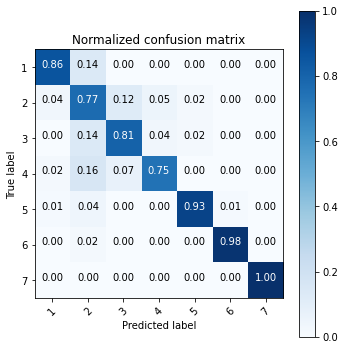

In [30]:
class_names = [1,2,3,4,5,6,7]

#Creacion de la matriz de confusion
cnf_matrix = confusion_matrix(y_test, y_test_pred)
np.set_printoptions(precision=2)
#Diagramacion de la matriz de confusion
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,title='Normalized confusion matrix')
plt.show()